In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from model import VAE
plt.style.use('ggplot')
%matplotlib inline



In [21]:
train = torchvision.datasets.MNIST(root="./mnist", train=True, download=True, transform=transforms.ToTensor())
test = torchvision.datasets.MNIST(root="./mnist", train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(train, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test, batch_size=128, shuffle=False)


In [5]:
model = torch.load("./mnist_vae.pth", map_location=torch.device('cpu'))


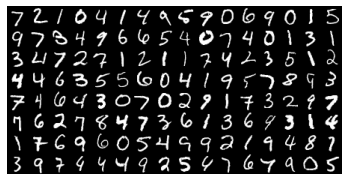

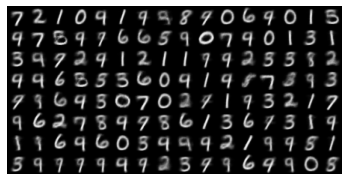

In [6]:
img_batch, _ = next(iter(test_dataloader))
img_batch_reconstr, _, _ = model(img_batch)
img_batch_reconstr = img_batch_reconstr.detach()

plt.imshow(
    torch.permute(make_grid(img_batch, nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

plt.imshow(
    torch.permute(make_grid(img_batch_reconstr, nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()


In [7]:
z_train = model.calculate_latent_var(train_dataloader, "cpu")
z_test = model.calculate_latent_var(test_dataloader, "cpu")


100%|██████████| 79/79 [00:01<00:00, 50.14it/s]


In [19]:
def extract_classes(dataloader, classes):
    inputs_list = []
    targets_list = []

    for x, y in tqdm(dataloader):
        idx = np.isin(y.numpy(), classes)
        inputs_list.append(x[idx])
        targets_list.append(y[idx])
    inputs = torch.cat(inputs_list)
    targets = torch.cat(targets_list)
    return DataLoader(TensorDataset(inputs, targets), batch_size=dataloader.batch_size, shuffle=True)


In [ ]:
# trans = TSNE(n_components=2, random_state=0)
# z_train_embed = trans.fit_transform(z_train)


1 6742
9 5949


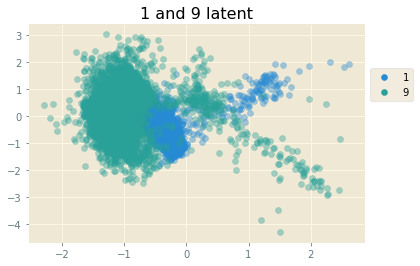

In [15]:
targets = train_dataloader.dataset.targets.numpy()
for i in [1, 9]:
    idx = np.where(targets == i)[0]
    print(i, len(idx))
    plt.scatter(
        x=z_train[idx, 0],
        y=z_train[idx, 1],
        label=i,
        alpha=0.4
    )
leg = plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("1 and 9 latent")
plt.show()


1 1135
9 1009


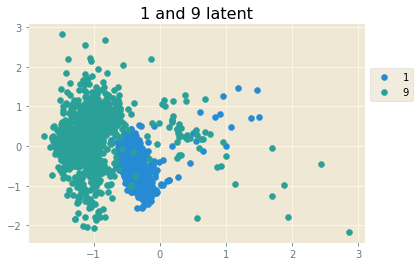

In [29]:
targets = test_dataloader.dataset.targets.numpy()
for i in [1, 9]:
    idx = np.where(targets == i)[0]
    print(i, len(idx))
    plt.scatter(
        x=z_test[idx, 0],
        y=z_test[idx, 1],
        label=i,
        alpha=1
    )
leg = plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("1 and 9 latent")
plt.show()


In [24]:
# sanity check on reconstruction over the test dataset
dl = extract_classes(test_dataloader, [1, 9])


100%|██████████| 79/79 [00:01<00:00, 60.80it/s]


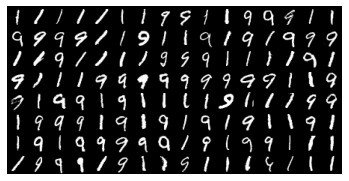

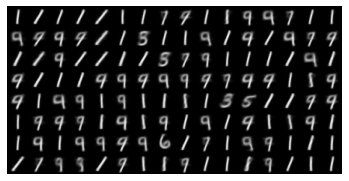

In [25]:
dl_iter = iter(dl)
img_batch, _ = next(dl_iter)
img_batch_reconstr, _, _ = model(
    img_batch
)
img_batch_reconstr = img_batch_reconstr.detach().cpu()

plt.imshow(
    torch.permute(make_grid(img_batch, nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()

plt.imshow(
    torch.permute(make_grid(img_batch_reconstr, nrow=16, padding=0), (1,2,0))
)
plt.axis("off")
plt.show()


In [26]:
idx = (train.targets == 1) + (train.targets == 9)
train.data = train.data[idx]
train.targets = train.targets[idx]
z_train_19 = z_train[idx]


In [27]:
z_train_19.shape


(12691, 2)

In [30]:
df = pd.DataFrame(
	data=np.column_stack([train.targets, z_train_19]),
	columns=["label"] + ["z" + str(i) for i in range(2)]
)
df.to_csv("./mnist_latent.csv", index=False)


In [31]:
df.head()


,label,z0,z1
0,1.0,-0.365721,-1.086663
1,9.0,-1.172632,0.161588
2,1.0,-0.505487,0.141448
3,1.0,-0.555526,0.038120
4,1.0,-0.525272,-0.045041


In [2]:
import matplotlib.pyplot as plt # noqa: E402


In [3]:
df = pd.read_csv("./mnist_latent_tsne.csv")
df.head()


,label,z0,z1,z2,z3,z4,z5,z6,z7,z_embed0,z_embed1
0,5.0,-0.211959,0.086863,0.097551,-0.383271,-0.288333,0.201068,-0.034572,0.356061,28.791779,-5.225217
1,3.0,-0.337944,0.071082,0.114442,-0.483089,-0.442730,0.475183,-0.110816,0.623883,29.934879,-2.909101
2,3.0,0.088763,0.101754,0.232076,-0.199906,0.079908,0.754755,-0.021086,0.044236,34.898613,-9.865219
3,5.0,-1.358968,0.151490,0.518935,0.055486,2.228035,-0.519679,0.707848,-0.209722,-14.293622,-6.455900
4,3.0,0.994458,0.070969,0.170349,-0.409696,-1.560363,0.942876,-0.509566,0.174537,47.764755,37.039379


5 5421
3 6131


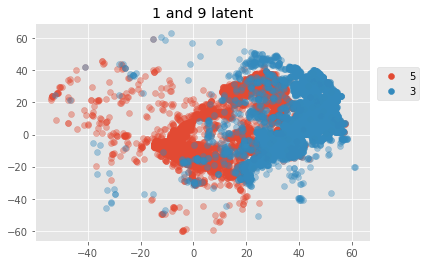

In [10]:
for i in [5, 3]:
    idx = np.where(df['label'].values == i)[0]
    print(i, len(idx))
    plt.scatter(
        x=df.values[idx, -2],
        y=df.values[idx, -1],
        label=i,
        alpha=0.4
    )
leg = plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("1 and 9 latent")
plt.show()

